<a href="https://colab.research.google.com/github/IrisGun/Decision-Tree-Predicting-survivals-from-the-Titanic-Disaster/blob/main/Trang_Nguyen_DA_22_02_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Problem 1 - Linear Regression: Predicting California House Price (50 points)


## Xây dựng mô hình dự đoán giá nhà ở bang California bằng hồi quy tuyến tính.

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# models
## Scikit-Learn
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Statsmodels
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression

# data
from sklearn.datasets import fetch_california_housing

# metrics
from sklearn.metrics import mean_squared_error, r2_score

# seaborn for visualization
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# statistics
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# # plotting
import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 10}
matplotlib.rc('font', **font)

## Helper function
# visualize the distribution of values a column, specified by 'column' ~ a column of a data frame, the name of the column is 'column_name' ~ a string
# trực quan hóa phân phối giá trị của 1 cột trong dataframe, 'column' là 1 cột của 1 dataframe, biến 'column_name' là tên của cột đó.
def visualize_distr(column_name, column):
    sns.distplot(column , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(column)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title(column_name + ' distribution')


## 1. Data loading (5 points)


Run the following code cell to load the data and create a data frame.\
Chạy đoạn code dưới dây để tải data và tạo ra 1 dataframe.

In [ ]:
# load the data
data = fetch_california_housing()

# create a Pandas Data Frame
df_features = pd.DataFrame(data['data'], columns=data['feature_names'])
df_targets  = pd.DataFrame(data['target'], columns=['value'])
# Concat the features and the target (df_targets is the output of our Linear Regression)
df = pd.concat([df_features, df_targets], axis=1)

Requirements:
  - Read dataset, then show the first 5 rows of the dataset. (2 points)\
  Gọi hàm thích hợp để in ra 5 dòng đầu của dataframe.

In [ ]:
# Print the first 5 rows of the data (2 points): 1 line of code
# YOUR CODE HERE
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Requirements:
  - Use `visualize_distr` function to plot the distribution of the column `value` ~ the target of our linear regression. (3 points)\
  Gọi hàm `visualize_distr` định nghĩa ở trên để trực quan hóa phân phối của giá trị cột `value`. 


 mu = 2.07 and sigma = 1.15



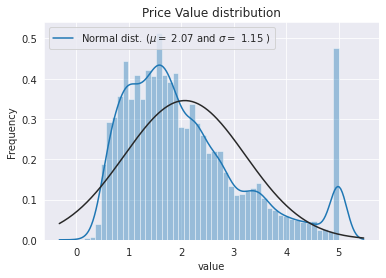

In [ ]:
# Use the helper function defined above to plot the distribution of value (3 points): 1 line of code
# YOUR CODE HERE
visualize_distr("Price Value",df.value)

## 2. Data Processing (15 points)

### 2.1 Fill in the misssing entries

Run the following code cell to confirm that there is no missing entries (fortunately!) ✌\
Chạy đoạn code dưới đây để xác nhận là không cột nào bị khuyết data.

In [ ]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate


### 2.2 Remove highly correlated variables (5 points)

Run the following code cell to check the pairwise correlation among the features.\
Chạy đoạn code dưới đây để tính hệ số tương quan của các cột features.

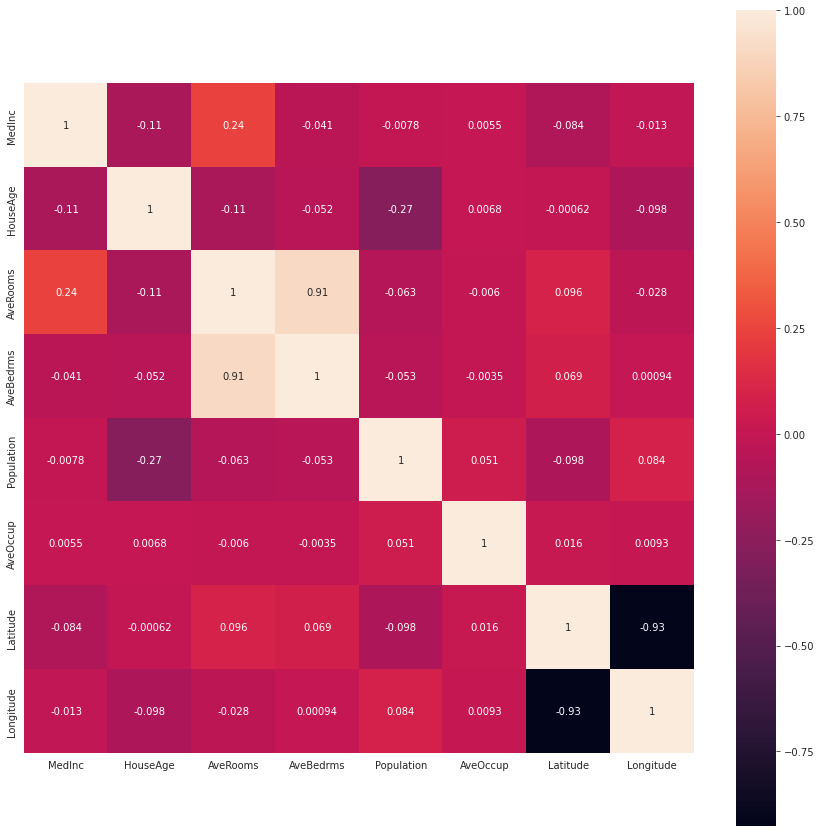

In [ ]:

# Calculate the Correlation matrix of data frame without Dependent variable (Just on 25% of data)
corr_matrix = df.drop(columns=['value'])._get_numeric_data().sample(frac=0.25).corr()

# Plot the heatmap of Correlation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

Run the following code cell to find the column pairs having correlation > 0.8 (or < -0.8). From each pair, the code indentifies 1 column to remove.\
Chạy đoạn code dưới đây để tìm ra các cặp cột có hệ số tương quan > 0.8 (hoặc < -0.8). Từ mỗi cặp, Python sẽ lấy ra 1 cột để gỡ đi.

In [ ]:
# threshold above which is considered too high of a correlation. Complete this line of code by filling in the appropriate value (1 point)
corr_threshold = 0.8

# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than the correlation threshold (which are the unnecessary columns and will be dropped)
to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]

Requirements:
- Complete the following code cell so that `train_df` will be our training data after dropping the unnecessary columns. The unnecessary columns are specified in `to_drop_corr`.  (5 points)\
Hoàn thành đoạn code đươi dây để `train_df` là dataframe mới sau khi bỏ đi những cột cần bỏ. Tên của những cột cần bỏ được lưu trong list `to_drop_corr`.

In [ ]:
# Complete the following line: train_df is the data frame obtained by dropping the unnecessary columns (5 points).
train_df = df.drop(columns=to_drop_corr)



### 2.3 Feature Scaling (5 points)

Run the following code cell to extract indices the data column (excluding the `value` column). The indices of the data column will be in the variable `input_cols`.\
Chạy đoạn code dưới đây. Sau khi hoàn thành, `input_cols` sẽ là 1 list lưu tên của những cột được dùng trong việc phát triển mô hình và đưa ra dự đoán.

In [ ]:
# Exclude the value (target of prediction) column and select all numerical columns
input_cols = train_df.drop(columns=['value']).select_dtypes(include='number').columns
print(input_cols)
train_df[input_cols].head()

Index(['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude'], dtype='object')


,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude
0,8.3252,41.0,6.984127,322.0,2.555556,37.88
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86
2,7.2574,52.0,8.288136,496.0,2.802260,37.85
3,5.6431,52.0,5.817352,558.0,2.547945,37.85
4,3.8462,52.0,6.281853,565.0,2.181467,37.85


Complete the following code cell to Min-Max Scale the data (5 points).<br> 
Dùng Min-Max Scaler để scale các cột dữ liệu về cùng 1 khoảng giá trị 0-1.\
Requirements:
- Define a MinMax Scaler (1 point). Gọi ra 1 MinMax Scaler.
- Fit the scaler to our data and return the scaled data to `scaled_df` (2 points). NOTE: only fit the scaler to the input columns (excluding the 'value' column). Lưu ý: chỉ sử dụng `train_df[input_cols]`.
- Scale the data by 1 line of code (1 point).
- Describe the scaled data with count, mean, std, min,... (1 point).

In [ ]:
train_df[input_cols]

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude
0,8.3252,41.0,6.984127,322.0,2.555556,37.88
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86
2,7.2574,52.0,8.288136,496.0,2.802260,37.85
3,5.6431,52.0,5.817352,558.0,2.547945,37.85
4,3.8462,52.0,6.281853,565.0,2.181467,37.85
...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,845.0,2.560606,39.48
20636,2.5568,18.0,6.114035,356.0,3.122807,39.49
20637,1.7000,17.0,5.205543,1007.0,2.325635,39.43
20638,1.8672,18.0,5.329513,741.0,2.123209,39.43


In [ ]:
# Define a MinMax Scaler (1 point)
scaler = MinMaxScaler()

# Fit the scaler to our data and return the scaled data into 'scaled_df' (2 points). NOTE: only fit to the input columns (excluding the 'value' column).
scaled_df = scaler.fit_transform(train_df[input_cols])

# scale our data (1 point)
train_df[input_cols] = scaled_df

# describe the scaled data with count, mean, std, min,... (1 point)
train_df.describe()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.232464,0.541951,0.032488,0.039869,0.001914,0.328572,2.068558
std,0.131020,0.246776,0.017539,0.031740,0.008358,0.226988,1.153956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149990
25%,0.142308,0.333333,0.025482,0.021974,0.001398,0.147715,1.196000
50%,0.209301,0.549020,0.031071,0.032596,0.001711,0.182784,1.797000
75%,0.292641,0.705882,0.036907,0.048264,0.002084,0.549416,2.647250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000010


### 2.4 Train-Test Split (5 points)

Requirements:
- Split the data into `X_train, y_train, X_test, y_test` with the defined `test_size_ratio` (5 points).\
Chia dữ liệu thành 1 tập train-test với tỷ lệ 80-20. Lưu ý là `X_train` và `X_test` không được chứa cột `value`.

In [ ]:
# Split the data into X_train, X_test, y_train, and y_test with the defined test_size_ratio (5 points). NOTE: X_train and X_test only contain the input columns, NOT the 'value' column.
test_size_ratio=0.2
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['value']), train_df.value, 
                                                    test_size=test_size_ratio,random_state=1)

Run the following code cell to print the shape of `X_train, y_train, X_test, y_test`.\
In ra kích thước của các tập dữ liệu vừa chia.



In [ ]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (16512, 6)
y_train.shape: (16512,)
X_test.shape: (4128, 6)
y_test.shape: (4128,)


## 3. Linear Regression with scikit-learn (15 points)

### 3.1 Basic (10 points)

Requirements:
- Train a linear regression model on the train set.\
Dùng linear regression để học dữ liệu train.

In [ ]:
reg_model=LinearRegression().fit(X_train,y_train)

Requirements:
- Use the trained linear regression model to make predictions on the test set.\
Dùng mô hình linear regression vừa mới trained để dự đoán trên tập test.

In [ ]:
y_pred=reg_model.predict(X_test)

Requirements:
- Print the R-squared and Root Mean Squared Error.\
Đánh giá mô hình với 2 tiêu chí là R-squared và Root Mean Squared Error và in ra.

In [ ]:
# Evaluation on Test set
# Print R-squared (1 point)
print(f'R-squared = {r2_score(y_test,y_pred):.4f}')
# Print Mean Squared Error (1 point)
print(f'MSE       = {mean_squared_error(y_test,y_pred):.2f}')


reg_r2 = r2_score(y_test,y_pred)
reg_mse= mean_squared_error(y_test,y_pred)

R-squared = 0.5167
MSE       = 0.63


### 3.2 Variance Inflation Factor (5 poitns)

Requirements:
- Complete the following code cell so that `vif["VIF Factor"]` will be the VIF of EACH column of `X_train`.\
Hoàn thành đoạn code để `vif["VIF Factor"]` sẽ là Variance Inflation Factor của các cột trong `X_train`.




In [ ]:
vif = pd.DataFrame()
# Complete the following line so that 'vif["VIF Factor"]' will be a column of VIF of each column of X_train.
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif["features"] = X_train.columns
vif

,VIF Factor,features
0,4.084838,MedInc
1,3.291107,HouseAge
2,4.139080,AveRooms
3,2.097812,Population
4,1.051249,AveOccup
5,2.795096,Latitude


Requirements:
- Repeat the whole Linear Regression training, prediction, and evaluation process with only the input columns associated with VIF < 10. (2 points)\
Lặp lại quá trình chia tập train-set, train mô hình, dự đoán, và đánh giá mô hình Linear Regression. Tuy nhiên, chỉ sử dụng những cột input có VIF < 10.

In [ ]:
# selected_cols: the columns having VIF < 10.
vif_threshold = 10
input_cols_vif = vif[vif['VIF Factor']<vif_threshold].features
selected_cols  = input_cols[input_cols.isin(input_cols_vif)]


# Split the data into X_train, X_test, y_train, and y_test with the defined test_size_ratio. NOTE: X_train and X_test only contain the selected columns.
# YOUR CODE HERE
#Scale
train_df[selected_cols] = MinMaxScaler().fit_transform(train_df[selected_cols])

#Split
test_size_ratio=0.2
X_train, X_test, y_train, y_test= train_test_split(train_df[selected_cols],train_df.value,
                                                   test_size=test_size_ratio,random_state=1)

# Train the model on the train set & Predict on the test set
reg_model_vif = LinearRegression().fit(X_train,y_train)
y_pred = reg_model_vif.predict(X_test)

# Evaluation on Test set: R-squared and Root Mean Squared Error.
reg_vif_r2 = r2_score(y_test,y_pred)
reg_vif_MSE = mean_squared_error(y_test,y_pred)
# Print R-squared
print(f'R-squared = {r2_score(y_test,y_pred):.4f}')
# Print Root Mean Squared Error
print(f'MSE = {mean_squared_error(y_test,y_pred):.4f}')


R-squared = 0.5167
MSE = 0.6339


Requirements:
- What do you think about this performance?\
Bạn đánh giá thế nào về kết quả này? Tại sao lại như vậy?

In [ ]:
## YOUR ANSWER HERE ##
reg_metric=list(zip(['Reg', 'Reg_VIF'],[reg_r2,reg_vif_r2],[reg_mse, reg_vif_MSE]))
pd.DataFrame(reg_metric, columns=['Model','R2','MSE'])

,Model,R2,MSE
0,Reg,0.516699,0.633941
1,Reg_VIF,0.516699,0.633941


__Nhận xét:__ 
- Sau khi bỏ 2 biến có VIF>10, mô hình có chỉ số R2 giảm và MSE tăng \
=> Mô hình ban đầu trước khi loại bỏ 2 biến nhìn chung có kết quả tốt hơn.\
=> Việc loại bỏ biến tương quan dựa vào VIF (VIF>10) có vẻ không hiệu quả trong trường hợp này khi so sánh với việc sử dụng hệ số correlation (corr>0.8)

In [ ]:
train_df.describe()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.232464,0.541951,0.032488,0.039869,0.001914,0.328572,2.068558
std,0.131020,0.246776,0.017539,0.031740,0.008358,0.226988,1.153956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149990
25%,0.142308,0.333333,0.025482,0.021974,0.001398,0.147715,1.196000
50%,0.209301,0.549020,0.031071,0.032596,0.001711,0.182784,1.797000
75%,0.292641,0.705882,0.036907,0.048264,0.002084,0.549416,2.647250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000010


- value dao động từ khoảng 0.1499 đến 5.0000, trong khi MSE>0.6 chứng tỏ cả 2 mô hình đều Regression đều chưa đủ tốt 
- R-squared ~50% là các biến trong mô hình chỉ giải thichs được khoảng 50% đầu ra

__Từ các kết luận trên:__
- Chọn một mô hình khác powerful hơn
- Thay đổi feature đầu vào (collect thêm data, select features tốt)


# 4. Interpret the model with `statsmodels` (5 points)

Requirements:
- Train-Test Split: 1 line of code.\
Chia lại tập train-test.
- Train & Interpret the model with `statsmodels`: 3 lines of code.\
Train và diễn giải mô hình với `statsmodels`

In [ ]:
# Train-Test Split according to the test_size_ratio defined above. Hint: 1 line of code.
X_train, X_test, y_train,y_test = train_test_split(train_df.drop(columns=['value']), train_df.value,
                                                   test_size=test_size_ratio, random_state=1)

# Train & Interpret the model with statsmodel. Hint: 3 lines of code.
est=sm.OLS(y_train,X_train)
est_2=est.fit()
print(est_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                          2.142e+04
Date:                Sun, 24 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:25:03   Log-Likelihood:                         -19787.
No. Observations:               16512   AIC:                                  3.959e+04
Df Residuals:                   16506   BIC:                                  3.963e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#VIF-based feature removed model:

X_train_vif, X_test_vif, y_train_vif, y_test_vif = train_test_split(train_df[selected_cols], train_df.value,
                                                   test_size=test_size_ratio, random_state=1)

# Train & Interpret the model with statsmodel. Hint: 3 lines of code.
est=sm.OLS(y_train_vif,X_train_vif)
est_vif=est.fit()
print(est_vif.summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                          2.142e+04
Date:                Sun, 24 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:25:03   Log-Likelihood:                         -19787.
No. Observations:               16512   AIC:                                  3.959e+04
Df Residuals:                   16506   BIC:                                  3.963e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<br> Requirements:
- Type your answer to the question: looking at the above interpretation, should we remove any variable/features? Why? (1 point)\
Nhìn vào kết quả này, theo bạn chúng ta có nên bỏ đi features nào không? Tại sao?

In [ ]:
# Answer to the question (1 point): the variables/features we should remove is/are: . Reason: 


Từ kết quả có thể nhận định những điểm sau:
- p-value của các biến đều <1% => Các biến đều có ý nghĩa thống kê với mô hình
- Mô hình chưa bỏ bớt biến có Adjusted R-squared slightly higher 
- Đây không phải là mô hình lớn và phức tạp (<10 features, ~20k rows in total), computing cost không phải một trở ngại lớn. 

Từ các quan sát trên có thể kết luận:\
*Actually  no features should be removed at this point.*

## 5. (Advanced topics) Select features with `statsmodels` and `seletKbest` (10 points)

Requirements: (5 points)
- Use `selectKBest` to select the best 5 features.\
Sử dụng `selectKBest` để chọn ra 5 thuộc tính tốt nhất.
- Repeat the process: train-test split, train, predict on the test set, and evaluate the model.\
Lặp lại quá trình chia tập train-test, train mô hình, dự đoán trên tập test, đánh giá hiệu quả của mô hình.

In [ ]:
print(X_train.shape)
n=5
selector = SelectKBest(f_regression, k=n)
selector.fit(X_train,y_train)
X_new=selector.transform(X_train)
print('{} best selected features are: {}'.format(n, selector.get_feature_names_out()))


(16512, 6)
5 best selected features are: ['MedInc' 'HouseAge' 'AveRooms' 'Population' 'Latitude']


In [ ]:
# Select KBest: 4 points.
# Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['value']),train_df.value,
                                                    test_size=test_size_ratio,random_state=1)

# Number of selected features: 4 <?> The requirement about stated number 5 so I will stick with 5 features instead of 4
n=5
selector = SelectKBest(f_regression, k=n)
selector.fit(X_train,y_train)
print('{} best selected features are: {}'.format(n, selector.get_feature_names_out()))
X_train_selected = selector.transform(X_train)


# Create linear regression object & train on the training set
reg_model_1= LinearRegression().fit(X_train_selected, y_train)

# Predict on Test set
X_test_selected = selector.transform(X_test) 
y_pred = reg_model_1.predict(X_test_selected)

# Evaluation on Test set
# R-squared
print('R2: ',r2_score(y_test,y_pred))
# Mean Squared Error
print('MSE: ',mean_squared_error(y_test, y_pred))


5 best selected features are: ['MedInc' 'HouseAge' 'AveRooms' 'Population' 'Latitude']
R2:  0.5155344647727533
MSE:  0.6354690065788394


Requirements: (5 points)
- Select the features with `p-value` < 0.05.\
Lọc ra những features có p-value < 0.05.
- Repeat the process: train-test split, train, predict on the test set, and evaluate the model with the chosen features.\
Lặp lại quá trình chia tập train-test, train mô hình, dự đoán trên tập test, đánh giá hiệu quả của mô hình. Chỉ sử dụng những features được lọc ra.

In [ ]:
# p-values: 4 points.
# Compute F-statistics and p-values
f,p = f_regression(X_train, y_train)

# Create a DataFrame for F-statistics and p-values
df_significance = pd.DataFrame({'Feature': train_df.drop(columns='value').select_dtypes(include='number').columns,
                                'F-statistics': f, 'p-value':p})
display(df_significance)

# Select the features associated with p-values < significance level
alpha=0.05
selected_features = df_significance[df_significance['p-value']<alpha]['Feature']

# Split Train-Test, Create object, Train, Test, and Evaluate.

X_train2, X_test2, y_train2, y_test2 = train_test_split(train_df[list(selected_features)],train_df.value,
                                                        test_size=test_size_ratio,random_state=1)
reg_model_2 = LinearRegression().fit(X_train2, y_train2)
y_pred2 = reg_model_2.predict(X_test2)

# Evaluation on Test set
# R-squared
print('R2: ',r2_score(y_test2,y_pred2))
# Mean Squared Error
print('MSE: ',mean_squared_error(y_test2, y_pred2))

,Feature,F-statistics,p-value
0,MedInc,14854.602105,0.000000e+00
1,HouseAge,186.749135,2.767101e-42
2,AveRooms,362.155218,6.840794e-80
3,Population,9.423725,2.145436e-03
4,AveOccup,7.979570,4.736491e-03
5,Latitude,327.062183,2.095139e-72


R2:  0.5166991309718191
MSE:  0.6339413245897191


## 6. Random Forest Regression (Optional).

---



Complete the following code cell to do Regression using Random Forest. Learners are encouraged to complete this part.\
Dùng Random Forest cho bài toán hồi quy của chúng ta. Khuyến khích học viên hoàn thành phần này.

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['value']),train_df.value,
                                                    test_size=test_size_ratio,random_state=1)


# Create Random Forest regressor object & Train the model on the Training set.
rfr = RandomForestRegressor(random_state=1)
rfr.fit(X_train, y_train)

# Predict on the Test set
y_pred=rfr.predict(X_test)


# Evaluation on Test set: R-squared & Root Mean squared Error. 
print('R2: ',r2_score(y_test,y_pred))
# Mean Squared Error
print('MSE: ',mean_squared_error(y_test, y_pred))




R2:  0.7314601060665793
MSE:  0.35224132000352126


## 7. Decision Tree Regression (Optional).


Complete the following code cell to do Regression using Decision Tree. Learners are encouraged to complete this part.\
Dùng Decision Tree cho bài toán hồi quy của chúng ta. Khuyến khích học viên hoàn thành phần này.

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['value']),train_df.value,
                                                    test_size=test_size_ratio,random_state=1)


# Create Decision Tree regressor object & Train the model on the Training set.
dtreg = DecisionTreeRegressor(random_state=1)
dtreg.fit(X_train, y_train)

# Predict on the Test set
y_pred = dtreg.predict(X_test)


# Evaluation on Test set: R-squared & Root Mean squared Error. 
print('R2: ',r2_score(y_test,y_pred))
# Mean Squared Error
print('MSE: ',mean_squared_error(y_test, y_pred))


R2:  0.48975042954251935
MSE:  0.6692896895004118


# Problem 2 - Decision Tree: Predicting survivals from the Titanic Disaster (50 points)




## Xây dựng mô hình dự đoán người sống sốt sau thảm họa tàu Titanic.

https://query.data.world/s/ckuvwmg55m3tkazkrw3u2os35jm6cg

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier



# plotting
import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 18}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)

## 1. Data loading (10 points)
Requirement:
  - Load the dataset from csv to pandas. (5 points)

In [ ]:
## YOUR CODE HERE ##
data='https://query.data.world/s/ckuvwmg55m3tkazkrw3u2os35jm6cg'
df=pd.read_csv(data)
print(df.shape)
df.head(n=20)
df.tail()

(1310, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1305,3.0,0.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN
1309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



First glance and Summary:\
__Feature:__


1.   survival: 0 - No, 1 - Yes
2.   calss: Passenger Class (1st, 2nd, 3rd)
3. sibsp: Number of Siblings/Spouses Abroard
4. parch - Number of Parents/Children Aboard
5. ticket: Ticket number
6. fare: Passenger Fare
7. embarked: Port of Embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)
8. boat: Lifeboat (if survived)
9. body: Body number (if did not survive and body was recovered)
10. home_dest: Home destination (?)
11. name: Name of passensger which includes their title after the comma regarding gender and marital status such as Mr., Ms., .. job and position such as Col. (colonel), Dr., etc.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.4+ KB


  - Break down the dataset into X (features) and y(label) ~ to be predicted. (5 points)\
  Chia dữ liệu thành X (features) và y (label) cần dự đoán.

In [ ]:
#The last row only contains index => drop
df=df[:-1]
df.isnull().sum()/len(df)*100

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

In [ ]:
## YOUR CODE HERE ##
X = df.drop(columns=['survived','boat'])
y = df.survived

## 2. Data preprocessing (15 points)

Requirement:
  - Convert the text data into numerical data.\
  Chuyển dữ liệu dạng chữ thành dạng số.

In [ ]:
## YOUR CODE HERE ##
df.info()
for i in df.select_dtypes(include='object'):
  print(i, df[i].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.3+ KB
name 1307
sex 2
ticket 929
cabin 186
embarked 3
boat 27
home.dest 369


_Idea_ \
1. _name_ \
Unique name seems not useful at all => Extract only title and see if it has any contribution as the title may reflect passenger's social status and it deems to effect their chance of survive.\
Obtain the title by splitting name to take only string after the comma (,) and before the period (.)

2. _cabin_ \
Cabin may have slight effect on the survival chance of the passenger. For example the nearer the cabin is to the stairs, the higher chance they may survival. \
But as no such information can be seen from the dataset and missing rate is fairly high => DROP this columns. \
Same thing happens to *'ticket', 'body', and 'home.dest'* column as they show no rational contribution.



In [ ]:
#Obtain title column:
df['title']=df['name'].str.split('.').str[0]
df['title']=df['title'].str.split(', ').str[1]
df.head()


#Drop columns
df.drop(columns=['name','ticket','cabin','body','home.dest'], axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,boat,title
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S,2,Miss
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S,11,Master
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S,NaN,Miss
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S,NaN,Mr
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S,NaN,Mrs


In [ ]:
df.info()
df.drop(columns=['boat'])
for i in df.select_dtypes(include=['object']):
  print(i, df[i].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   float64
 5   parch     1309 non-null   float64
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
 8   boat      486 non-null    object 
 9   title     1309 non-null   object 
dtypes: float64(6), object(4)
memory usage: 102.4+ KB
sex male      843
female    466
Name: sex, dtype: int64
embarked S    914
C    270
Q    123
Name: embarked, dtype: int64
boat 13         39
C          38
15         37
14         33
4          31
10         29
5          27
3          26
9          25
11         25
16         23
8          23
7          23
D          20
6          20
12         19
2          13
A      

#### Ideas for encoding:


1.   __boat__ \
is an ambiguous column: this colum shows number of life boats avaible or code name of the boat?
As the analysist (a.k.a me) can not find any desription of this column \
=> The Analysist will *assign 1 for non-null and 0 for NA*

2. __embarked__ \
Encoded by pd.get_dummies

3. __title__ \
* There are some titles that specify passengers' high social status like: the Countess, Jonkheer, Sir, etc. => Group them into one category called "Noble"
* Some categories seem mispelling or inconsistent: Mlle, Mme \
_Note: the catergorization is relatively acceptable only as I have limited knowledge in this field. \
(Oh gosh it was like a Western history class now_  ㅠㅠ)
* As per above assumption, __title__ should be encoded as an ordinal catergorical variable. 
4. __pclass__\
has d_type as float but it's actually a ordinal catergorical variable => Let it be

In [ ]:
#ENCODING: 4 columns that need to be encoded: sex, embarked, boat, title.

#Encoding gender
df['sex']=df.sex.apply(lambda x:0 if x=='female' else 1)

#Encoding boat
#boat is an ambiguous column: this colum shows number of life boats avaible or code name of the boat?
#as the analysist (a.k.a me) can not find any desription of this column
#=> The Analysist will assign 1 for non-null and 0 for NA
#df['boat']=df['boat'].notnull().astype(int)
#df.head()


In [ ]:
#Encode title

#Show number of survivals/total number of people grouped by their title.
df.groupby(['title']).mean().sort_values(['survived'], ascending=False)['survived']

title
the Countess    1.000000
Mlle            1.000000
Sir             1.000000
Dona            1.000000
Mme             1.000000
Lady            1.000000
Mrs             0.786802
Miss            0.676923
Master          0.508197
Col             0.500000
Major           0.500000
Dr              0.500000
Ms              0.500000
Mr              0.162483
Jonkheer        0.000000
Rev             0.000000
Don             0.000000
Capt            0.000000
Name: survived, dtype: float64

From the above mean (number of survivors divided by total number of people belong to the title group) the Analysist assume the survival chance related to title as: \
Man: 1 \
Master: 2 \
Miss: 3 \
Mrs: 4 \
Noble: 5

In [ ]:
df['title_']=df['title']
df['title_']=df['title_'].replace(['the Countess', 'Dona', 'Lady', 'Col', 'Capt', 'Dr', 'Jonkheer',
                                 'Rev', 'Don', 'Sir', 'Major'], 'Noble')
df['title_'] = df['title_'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
df.title_.value_counts()
#df.groupby(['title_']).mean().sort_values(['survived'], ascending=False)['survived']

Mr        757
Miss      264
Mrs       198
Master     61
Noble      29
Name: title_, dtype: int64

In [ ]:
df['title_'] = df.title_.map({'Mr':1, 'Miss':3, 'Mrs':4, 'Master': 2, 'Noble': 5})
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,boat,title,title_
0,1.0,1.0,0,29.0000,0.0,0.0,211.3375,S,2,Miss,3
1,1.0,1.0,1,0.9167,1.0,2.0,151.5500,S,11,Master,2
2,1.0,0.0,0,2.0000,1.0,2.0,151.5500,S,NaN,Miss,3
3,1.0,0.0,1,30.0000,1.0,2.0,151.5500,S,NaN,Mr,1
4,1.0,0.0,0,25.0000,1.0,2.0,151.5500,S,NaN,Mrs,4


In [ ]:
#Encode embarked:

df_2=pd.get_dummies(df, columns=['embarked'], drop_first= True)

df_2.drop(columns=['boat'])
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   float64
 1   survived    1309 non-null   float64
 2   sex         1309 non-null   int64  
 3   age         1046 non-null   float64
 4   sibsp       1309 non-null   float64
 5   parch       1309 non-null   float64
 6   fare        1308 non-null   float64
 7   boat        486 non-null    object 
 8   title       1309 non-null   object 
 9   title_      1309 non-null   int64  
 10  embarked_Q  1309 non-null   uint8  
 11  embarked_S  1309 non-null   uint8  
dtypes: float64(6), int64(2), object(2), uint8(2)
memory usage: 104.9+ KB


In [ ]:
#Impute numeric Nan value with mean;
for i in df_2[['age','fare']]:
  df_2[i].fillna(df_2[i].mean(), inplace=True)
  
df_2.drop(columns=['boat'], inplace= True)
df_2.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   float64
 1   survived    1309 non-null   float64
 2   sex         1309 non-null   int64  
 3   age         1309 non-null   float64
 4   sibsp       1309 non-null   float64
 5   parch       1309 non-null   float64
 6   fare        1309 non-null   float64
 7   title       1309 non-null   object 
 8   title_      1309 non-null   int64  
 9   embarked_Q  1309 non-null   uint8  
 10  embarked_S  1309 non-null   uint8  
dtypes: float64(6), int64(2), object(1), uint8(2)
memory usage: 94.7+ KB


## 3. Train (25 points)

Requirement:
- Split the dataset into train & test sets. (5 points)\
Chia dữ liệu thành 2 tập train và test.

In [ ]:
## YOUR CODE HERE ##
test_size_ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(df_2.drop(columns=['survived', 'title']), df_2.survived,
                                                    test_size=test_size_ratio, random_state=1)

Requirement:
- Train a Decision tree classifier on the train set. (20 points)\
Dùng decision tree để học dữ liệu train.

In [ ]:
## YOUR CODE HERE ##
DT_classifier = DecisionTreeClassifier().fit(X_train, y_train)

## 4. Predict & Test (30 points)
Requirement:
- Use the trained decision tree classifier to make predictions on the test set. (15 points)\
Dùng decision tree để dự đoán dữ liệu test.

In [ ]:
## YOUR CODE HERE ##
y_pred = DT_classifier.predict(X_test)


Requirement:
- Evaluate the predictions.\
Đo lường kết quả của mô hình. (15 points)

In [ ]:
## YOUR CODE HERE ##
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.732824427480916
0.6666666666666666
0.6624203821656051
0.6645367412140575


## 5. (Advanced topics) Analysis (20 points)
Requirement:
- Adjust some hyperparameters of the decision tree classifier (max_depth, min_sample_split) to improve the performance further. (10 points)\
Thử thay đổi các yếu tố trong decision trê để tìm ra mô hình tối ưu (max_depth, min_sample_split).


In [ ]:
## YOUR CODE HERE ##
from sklearn.model_selection import GridSearchCV 

params ={'max_depth': [2,50] , 'min_samples_split':[2,3,4,5]}

gridsearch = GridSearchCV(estimator = DecisionTreeClassifier(random_state=1),
             param_grid = params, verbose=4)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..max_depth=2, min_samples_split=2;, score=0.788 total time=   0.0s
[CV 2/5] END ..max_depth=2, min_samples_split=2;, score=0.814 total time=   0.0s
[CV 3/5] END ..max_depth=2, min_samples_split=2;, score=0.792 total time=   0.0s
[CV 4/5] END ..max_depth=2, min_samples_split=2;, score=0.792 total time=   0.0s
[CV 5/5] END ..max_depth=2, min_samples_split=2;, score=0.754 total time=   0.0s
[CV 1/5] END ..max_depth=2, min_samples_split=3;, score=0.788 total time=   0.0s
[CV 2/5] END ..max_depth=2, min_samples_split=3;, score=0.814 total time=   0.0s
[CV 3/5] END ..max_depth=2, min_samples_split=3;, score=0.792 total time=   0.0s
[CV 4/5] END ..max_depth=2, min_samples_split=3;, score=0.792 total time=   0.0s
[CV 5/5] END ..max_depth=2, min_samples_split=3;, score=0.754 total time=   0.0s
[CV 1/5] END ..max_depth=2, min_samples_split=4;, score=0.788 total time=   0.0s
[CV 2/5] END ..max_depth=2, min_samples_split=4;,

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [2, 50],
                         'min_samples_split': [2, 3, 4, 5]},
             verbose=4)

In [ ]:
model_2=DecisionTreeClassifier(max_depth=2, min_samples_split=2).fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7760814249363868
0.896551724137931
0.4968152866242038
0.639344262295082


**Conclution:** From the above result => Select max_depth = 2, min_samples_split = 2 as this combination produce highest score with lowest computational cost.

Requirement:
- Estimate the feature importance and identify the features that are the most influential to the prediction of whether a passenger survives. (5 points)\
Tính feature importance và tìm ra các features nào ảnh hưởng lớn nhất đến việc dự đoán xem một hành khách có sống sót hay không.

In [ ]:
## YOUR CODE HERE ##

importance = DT_classifier.feature_importances_
importance_df = pd.DataFrame(list(zip(X_train.columns,importance)), 
                             columns = ['Feauture', 'Importance Score'])
importance_df.sort_values(['Importance Score'], ascending = False)

,Feauture,Importance Score
6,title_,0.325742
5,fare,0.262309
2,age,0.226833
0,pclass,0.108632
4,parch,0.024532
3,sibsp,0.023846
8,embarked_S,0.013494
7,embarked_Q,0.013487
1,sex,0.001125


Requirement:
- Are there any patterns in the group of passengers who have a high rate of survival? Why do you think it is the case? (5 points)\
Đưa ra nhận xét của bạn về patterns của nhóm sống sót cao và theo b ạn nghĩ tại sao lại như vậy.

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df.survived, x=df.title_, y=df.fare, z=df.age,
                    color = df.survived,
                    labels={'x': 'title', 'y': 'fare', 'z': 'age'})
fig.show()